# Yingting Guan Final Project Code

In [1]:
cd E:\courses\CSC594 Natural Language Processing\project\amazon-fine-food-reviews

E:\courses\CSC594 Natural Language Processing\project\amazon-fine-food-reviews


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
data=pd.read_csv('Reviews.csv')

In [4]:
reviews=data[['Text']]

In [5]:
reviews.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [6]:
print('Number of reviews',len(reviews))

Number of reviews 568454


#### Data filtering

In [7]:
product_id=sorted(data.ProductId)
len(set(product_id))

74258

In [8]:
catagories=dict()
current_id=None
for i in product_id:
    if i == current_id:
        catagories[i]+=1
    else:
        catagories[i]=1
        current_id=i

In [307]:
#a list of counts of product reviews in descending order
catagories_sort=sorted(catagories.items(),key=lambda x: x[1],reverse=True)

In [10]:
product_name=pd.read_csv('ProductName.csv',encoding="latin-1")

In [11]:
#capture all 'Popchips' and 'Kettle Brand' product idr from top 300 reviews counts
import re
popchip=[]
kettle_brand=[]
pop=re.compile('Popchips')
kettle=re.compile('Kettle Brand')
for i in range(len(product_name)):
    r1=re.search(pop,product_name.ProductName[i])
    r2=re.search(kettle,product_name.ProductName[i])
    if r1 != None:
        popchip.append(product_name.ProductId[i])
    if r2 != None:
        kettle_brand.append(product_name.ProductId[i])

In [309]:
print('Popchips product id list:\n',popchip,'\nKettle Brand product id list:\n',kettle_brand)

Popchips product id list:
 ['B000VK8AVK', 'B0013NUGDE', 'B001RVFEP2', 'B001RVFERK', 'B0026KNQSA', 'B0026KPDG8', 'B006HYLW32', 'B007M832YY', 'B007M83302', 'B001RVFDOO'] 
Kettle Brand product id list:
 ['B000G6O2QG', 'B0012XBD7I', 'B001SAXPEO', 'B004728MI4', 'B00472I5A4', 'B0058AMY10', 'B006WYSFZK', 'B000G6MBUA', 'B000G6RYNE', 'B000LKVD5U', 'B000LKXBL4', 'B0058AMY5G', 'B0058AMY74', 'B0058AMYTC']


In [13]:
popdf=data.ix[data['ProductId'].isin(popchip)]

In [14]:
popdf.shape

(5381, 10)

In [16]:
ketdf=data.ix[data['ProductId'].isin(kettle_brand)]

In [17]:
ketdf.shape

(3045, 10)

# Opinion Extraction

In [15]:
popdf_rew=popdf[['Text']]

In [18]:
ketdf_rew=ketdf[['Text']]

In [19]:
#Remove any HTML tags
from bs4 import BeautifulSoup
popdf_rew['Text']=popdf_rew['Text'].map(lambda x: BeautifulSoup(x, "lxml").get_text())
ketdf_rew['Text']=ketdf_rew['Text'].map(lambda x: BeautifulSoup(x, "lxml").get_text())

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
popdf_rew['features']='0'
ketdf_rew['features']='0'

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
import nltk
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [22]:
def extract_feat(review):
    sent_fea_list=[]    
    sents=sent_tokenize(review)
    for sent in sents:
        fea_list=[]
        chunk_list=[]
        word=nltk.word_tokenize(sent)
        tags=nltk.pos_tag(word)

        for i in range(len(tags)):
            if tags[i][1] not in ['NN','NNS','NNP','NNPS']:
                chunk_list.append(' ')
            else:
                chunk_list.append(tags[i][0])
        chunk_list=' '.join(chunk_list) #create feature phrase where nouns are adjacent             
        chunk_list=chunk_list.split('  ') #e.g."citrus","gelatin"->"citrus gelatin"           
        for j in chunk_list:                          
            if j != '':
                spe_char=re.findall(re.compile('\W'),j) #remove special characters
                if len(spe_char)>0:                      
                    for char in spe_char:
                        j=j.replace(char,' ')
                j=j.strip()
                j=lemmatizer.lemmatize(j)
                fea_list.append(j)
        if fea_list != ['']:
            sent_fea_list.append(fea_list)
    return sent_fea_list

In [23]:
for i in range(len(popdf_rew)):
    rew=popdf_rew['Text'].iloc[i]
    feat=extract_feat(rew)
    popdf_rew.iloc[i,1]=feat

for i in range(len(ketdf_rew)):
    rew=ketdf_rew['Text'].iloc[i]
    feat=extract_feat(rew)
    ketdf_rew.iloc[i,1]=feat

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
for i in range (5):
    print('Review:\n',popdf_rew['Text'].iloc[0])
    print('Feature words:\n',popdf_rew['features'].iloc[0],'\n')

Review:
 These chips are wonderful.  My kids and I all loved the salt and pepper.Each .8 oz bag was 100 calories, lots of chips for the calorie count.
Feature words:
 [['chip'], ['kid', 'salt', 'pepper Each', 'bag', 'calorie', 'lot', 'chip', 'calorie count']] 

Review:
 These chips are wonderful.  My kids and I all loved the salt and pepper.Each .8 oz bag was 100 calories, lots of chips for the calorie count.
Feature words:
 [['chip'], ['kid', 'salt', 'pepper Each', 'bag', 'calorie', 'lot', 'chip', 'calorie count']] 

Review:
 These chips are wonderful.  My kids and I all loved the salt and pepper.Each .8 oz bag was 100 calories, lots of chips for the calorie count.
Feature words:
 [['chip'], ['kid', 'salt', 'pepper Each', 'bag', 'calorie', 'lot', 'chip', 'calorie count']] 

Review:
 These chips are wonderful.  My kids and I all loved the salt and pepper.Each .8 oz bag was 100 calories, lots of chips for the calorie count.
Feature words:
 [['chip'], ['kid', 'salt', 'pepper Each', 'bag'

In [30]:
for i in range (5):
    print('Review:\n',ketdf_rew['Text'].iloc[0])
    print('Feature words:\n',ketdf_rew['features'].iloc[0],'\n')

Review:
 Great if you are cutting back on fat, they do resemble regular chips but are nothing like them. Extremely dry and hard.
Feature words:
 [['Great', 'fat', 'chip', 'nothing']] 

Review:
 Great if you are cutting back on fat, they do resemble regular chips but are nothing like them. Extremely dry and hard.
Feature words:
 [['Great', 'fat', 'chip', 'nothing']] 

Review:
 Great if you are cutting back on fat, they do resemble regular chips but are nothing like them. Extremely dry and hard.
Feature words:
 [['Great', 'fat', 'chip', 'nothing']] 

Review:
 Great if you are cutting back on fat, they do resemble regular chips but are nothing like them. Extremely dry and hard.
Feature words:
 [['Great', 'fat', 'chip', 'nothing']] 

Review:
 Great if you are cutting back on fat, they do resemble regular chips but are nothing like them. Extremely dry and hard.
Feature words:
 [['Great', 'fat', 'chip', 'nothing']] 



In [31]:
#create a list of all transactions
def createTrans(dataSet):
    trans=[]
    for l in dataSet.features:
        flatten = [item for sublist in l for item in sublist]
        trans.append(flatten)
    return trans

popdf_fea=createTrans(popdf_rew)
ketdf_fea=createTrans(ketdf_rew)

#create a list of all items/features in a store
def createItems(TransData):
    items = []
    for transaction in TransData:
        for x in transaction:
            if not x in items:
                items.append(x)
    items.sort()
    return items

pop_items=createItems(popdf_fea)
ket_items=createItems(ketdf_fea)

#calculate p-support
def frequency(trans, items):
    count={}
    for iid in items:
        pattern='^'+iid+'$'
        count[iid]=0
        for tid in trans:
            for x in tid:
                result=re.match(re.compile(pattern),x)
                if result != None:
                    count[iid]+=1
                    break   
    count=sorted(count.items(),key=lambda x: x[1],reverse=True)
    return count

pop_freq=frequency(popdf_fea,pop_items)
ket_freq=frequency(ketdf_fea,ket_items)

In [37]:
minSupport=0.1
pop_retList=[]
ket_retList=[]

for x in pop_freq:
    support=x[1]/len(pop_freq)
    if support >= minSupport:
        pop_retList.append(x[0])
print('Feature words for Popchips:\n',pop_retList,'\n')

for x in ket_freq:
    support=x[1]/len(ket_freq)
    if support >= minSupport:
        ket_retList.append(x[0])
print('Feature words for Kettle Brand:\n',ket_retList)

Feature words for Popchips:
 ['chip', 'flavor', 'bag', 'taste', 'calorie', 'snack', 'salt', 'Popchips', 'fat', 'Amazon', 'time', 'potato chips', 'salty', 'thing', 'texture', 'case', 'potato', 'product', 'lot', 'order', 'something', 'box', 'crunch', 'vinegar', 'store', 'BBQ', 'way', 'price'] 

Feature words for Kettle Brand:
 ['chip', 'bag', 'flavor', 'taste', 'salt', 'time', 'brand', 'Amazon', 'Kettle', 'potato chips', 'case', 'product', 'way', 'crunch', 'price', 'spicy', 'snack', 'lot', 'bit', 'thing', 'amount', 'box', 'order', 'Kettle chips', 'salty', 'spice', 'Salt', 'company', 'crunchy', 'one', 'size', 'vinegar', 'friend', 'Kettle Chips', 'Sea Salt', 'ginger', 'mouth', 'oil', 'potato chip']


In [38]:
#Select meaningful features
pop_delete_list=['Amazon','time','salty','thing','product','lot','order','something','store','way','potato chips','Popchips',
                'bag','case','box','potato']
for x in pop_delete_list:
    pop_retList.remove(x)

In [39]:
# Opinion Lexicon:positive and negtive words
pos_file=open('positive-words.txt')
pos_text=pos_file.readlines()
pos_word=pos_text[35:]
pos_word=[word[:-1] for word in pos_word]

neg_file=open('negative-words.txt')
neg_text=neg_file.readlines()
neg_word=neg_text[35:]
neg_word=[word[:-1] for word in neg_word]

In [283]:
pop_dict={}
pop_fea_dict={}
for x in pop_retList:
    pop_dict[x]=[]
    pop_fea_dict[x]=[]

#opinion words extracting
for i in range(len(popdf_rew)):#for loop each review
    sents=sent_tokenize(popdf_rew['Text'].iloc[i])
    for sent in sents:#for loop each sent in a review
        words=word_tokenize(sent)                 #token each sentence
        tags=nltk.pos_tag(words)

        for fea in pop_retList:                   #decide whether the feathure is mentioned
            for k in range(len(words)):
                if fea == words[k]:
                    if k < 2:                     #just take three words before and after the features into consideration
                        start=0                   #use start and end index to limite the tags range
                        end=k+3
                    elif k > len(words)-3:
                        end=len(words)
                        start=k-3
                    else:
                        start=k-3
                        end=k+3
                    tags_range=tags[start:end]
                    
                    score=0
                    count=0
                    for tag in tags_range:
                        if tag[0] not in pop_retList and tag[0] not in ['NN','NN','NNS','NNP','NNPS']:
                            if tag[0] in pos_word:
                                score+=1
                                count+=1
                                pop_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                            elif tag[0] in neg_word and tag[0]:
                                score-=1
                                count+=1
                                pop_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                            elif tag[1] in ['JJ','JJR','JJS']:
                                pop_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                                
                    if count !=0:
                        fea_score=score/count
                    else:
                        fea_score=0
                    pop_dict[fea].append(fea_score)

In [284]:
#print scores for each feature word
score_list=[]
for i in pop_retList:
    print('%12s\t%.2f'%(i,sum(pop_dict[i])/np.count_nonzero(pop_dict[i])))
    score_list.append(sum(pop_dict[i])/np.count_nonzero(pop_dict[i]))

        chip	0.71
      flavor	0.67
       taste	0.58
     calorie	0.48
       snack	0.93
        salt	0.57
         fat	0.59
     texture	0.68
      crunch	1.00
     vinegar	0.86
         BBQ	0.51
       price	0.86


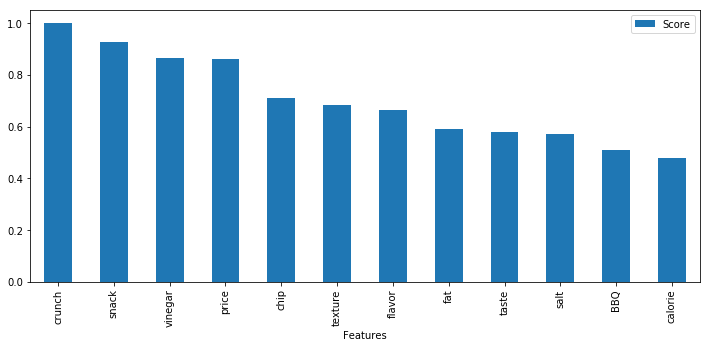

In [287]:
score_df=pd.DataFrame({'Features':pop_retList,'Score':score_list})
score_df.sort_values('Score',ascending=False,inplace=True)

%matplotlib inline
score_df.plot(kind='bar',x='Features',figsize=(12,5))

In [251]:
ket_delete_list=['time','brand','Amazon','Kettle','potato chips','product','way','spicy','lot','bit','thing',
                 'amount','order','Kettle chips','salty','company','crunchy','one','friend','Kettle Chips',
                 'mouth','potato chip','bag','case','box','Salt','Sea Salt']
for x in ket_delete_list:
    ket_retList.remove(x)

In [291]:
ket_dict={}
ket_fea_dict={}
for x in ket_retList:
    ket_dict[x]=[]
    ket_fea_dict[x]=[]

    #opinion words extracting
for i in range(len(ketdf_rew)):#for loop each review
    sents=sent_tokenize(ketdf_rew['Text'].iloc[i])
    for sent in sents:#for loop each sent in a review
        words=word_tokenize(sent)                 #token each sentence
        tags=nltk.pos_tag(words)

        for fea in ket_retList:                   #decide whether the feathure is mentioned
            for k in range(len(words)):
                if fea == words[k]:
                    if k < 2:                     #just take three words before and after the features into consideration
                        start=0                   #use start and end index to limite the tags range
                        end=k+3
                    elif k > len(words)-3:
                        end=len(words)
                        start=k-3
                    else:
                        start=k-3
                        end=k+3
                    tags_range=tags[start:end]
                    
                    score=0
                    count=0
                    for tag in tags_range:
                        if tag[0] not in ket_retList and tag[0] not in ['NN','NN','NNS','NNP','NNPS']:
                            if tag[0] in pos_word:
                                score+=1
                                count+=1
                                ket_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                            elif tag[0] in neg_word and tag[0]:
                                score-=1
                                count+=1
                                ket_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                            elif tag[1] in ['JJ','JJR','JJS']:
                                ket_fea_dict[fea].append(lemmatizer.lemmatize(tag[0]))
                                
                    if count !=0:
                        fea_score=score/count
                    else:
                        fea_score=0
                    ket_dict[fea].append(fea_score)

In [292]:
score_list=[]
for i in ket_retList:
    print('%12s\t%.2f'%(i,sum(ket_dict[i])/np.count_nonzero(ket_dict[i])))
    score_list.append(sum(ket_dict[i])/np.count_nonzero(ket_dict[i]))

        chip	0.65
      flavor	0.85
       taste	0.47
        salt	1.00
      crunch	1.00
       price	1.00
       snack	0.69
       spice	1.00
        size	0.80
     vinegar	1.00
      ginger	1.00
         oil	-1.00


In [262]:
score_df=pd.DataFrame({'Features':ket_retList,'Score':score_list})

In [263]:
score_df.sort_values('Score',ascending=False,inplace=True)

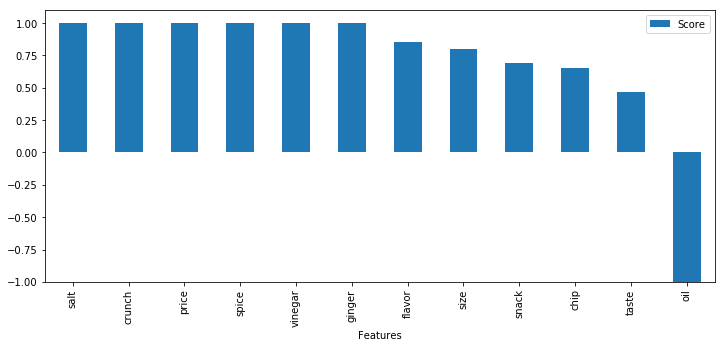

In [264]:
%matplotlib inline
score_df.plot(kind='bar',x='Features',figsize=(12,5))

In [289]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [302]:
#generate word cloud
def wordcloud(x,product):
    text=[]
    product=product.lower()
    if product=='popchips':
        for i in pop_fea_dict[x]:
            text.append(i)
        text=' '.join(text)
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=100,
                      max_font_size=60,collocations=False).generate(text)

        plt.figure(figsize=(11, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    elif product=='kettle brand':
        for i in ket_fea_dict[x]:
            text.append(i)
        text=' '.join(text)
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=100,
                      max_font_size=60,collocations=False).generate(text)

        plt.figure(figsize=(11, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        print('Product Name Error!')

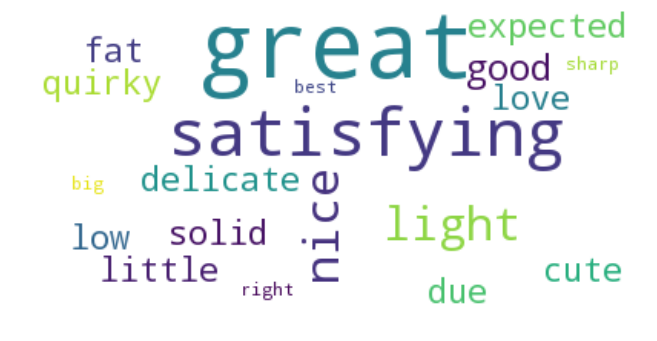

In [305]:
wordcloud('crunch','popchips')

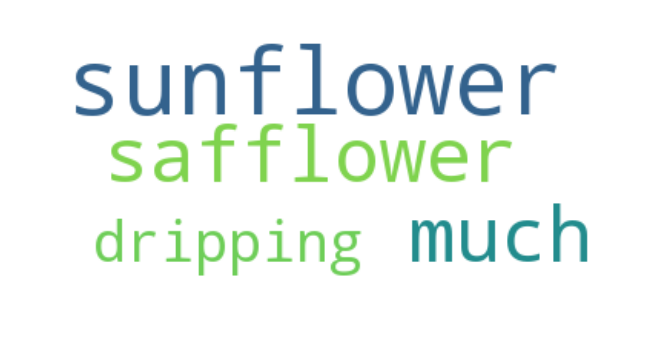

In [350]:
wordcloud('oil','kettle Brand')

# Sentiment classification

In [351]:
popdf['Text']=popdf_rew['Text']

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [352]:
popdf['Class']='0'

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [353]:
popdf['Class']=popdf[['Score']].astype(str)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [354]:
popdf['Class'].value_counts()

5    3534
4     850
3     442
1     279
2     276
Name: Class, dtype: int64

In [355]:
reviews=popdf.Text
Class=popdf.Class

In [356]:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.util import ngrams
from sklearn.cross_validation import train_test_split

In [357]:
x_train,x_test,y_train,y_test=train_test_split(reviews,Class,test_size=0.2,random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4304,)
(1077,)
(4304,)
(1077,)


In [358]:
#calculate class label probability
vneg_prob=(y_train=='1').sum()/len(y_train)
neg_prob=(y_train=='2').sum()/len(y_train)
neut_prob=(y_train=='3').sum()/len(y_train)
pos_prob=(y_train=='4').sum()/len(y_train)
vpos_prob=(y_train=='5').sum()/len(y_train)

In [359]:
print('very positive class probability:\n',vpos_prob,'\npositive class probability:\n',pos_prob,'\nneutral class probability:\n',neut_prob,'\nnegative class probability:\n',neg_prob,'\nvery negative class probability:\n',vneg_prob)

very positive class probability:
 0.657295539033 
positive class probability:
 0.157295539033 
neutral class probability:
 0.083875464684 
negative class probability:
 0.0506505576208 
very negative class probability:
 0.0508828996283


### Unigram

In [427]:
from nltk.corpus import stopwords

In [428]:
stopwords=set(stopwords.words('english'))

In [450]:
uni_train=set()
#extract all unique bigram from reviews
for i in x_train: 
    sents=sent_tokenize(i)
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        uni_train=set(set(words)|uni_train)

In [451]:
#add unkown unigram type
uni_train.add('UNK')

In [452]:
V=len(uni_train)
print('# of unique unigrams:',V)

# of unique unigrams: 4503


In [453]:
#create and fill in unigram emission table
tablesize=np.zeros(shape=(V,5))
uni_df=pd.DataFrame(tablesize,columns=['1','2','3','4','5'],index=uni_train)

for i in range(len(x_train)):
    c=str(y_train.iloc[i])
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        for w in words:
            uni_df[c][w]+=1

In [454]:
vneg_N=sum(uni_df['1'])
neg_N=sum(uni_df['2'])
neut_N=sum(uni_df['3'])
pos_N=sum(uni_df['4'])
vpos_N=sum(uni_df['5'])

print('total counts of unigrams in very positive class:',vpos_N)
print('total counts of unigrams in positive class:',pos_N)
print('total counts of unigrams in neutral class:',neut_N)
print('total counts of unigrams in negtive class:',neg_N)
print('total counts of unigrams in very negtive class:',vneg_N)

total counts of unigrams in very positive class: 141822.0
total counts of unigrams in positive class: 46336.0
total counts of unigrams in neutral class: 22011.0
total counts of unigrams in negtive class: 12842.0
total counts of unigrams in very negtive class: 10318.0


In [455]:
#smooth emission table and create probability unigram table
uni_count=np.array(uni_df)

for i in range(len(uni_count)):
    uni_count[i][0]=np.log((uni_count[i][0]+1)/(vneg_N+V))+np.log(vneg_prob)
    uni_count[i][1]=np.log((uni_count[i][1]+1)/(neg_N+V))+np.log(neg_prob)
    uni_count[i][2]=np.log((uni_count[i][2]+1)/(neut_N+V))+np.log(neut_prob)
    uni_count[i][3]=np.log((uni_count[i][3]+1)/(pos_N+V))+np.log(pos_prob)
    uni_count[i][4]=np.log((uni_count[i][4]+1)/(vpos_N+V))+np.log(vpos_prob)

In [456]:
uni_prob=pd.DataFrame(uni_count,columns=['1','2','3','4','5'],index=uni_train)

In [458]:
#predict training set sentiment class
class_list_train=[]
for i in range(len(x_train)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        for w in words:
            if w in uni_train:
                vneg_score+=uni_prob['1'][w]
                neg_score+=uni_prob['2'][w]
                neut_score+=uni_prob['3'][w]
                pos_score+=uni_prob['4'][w]
                vpos_score+=uni_prob['5'][w]
            else:
                vneg_score+=uni_prob['1']['UNK']
                neg_score+=uni_prob['2']['UNK']
                neut_score+=uni_prob['3']['UNK']
                pos_score+=uni_prob['4']['UNK']
                vpos_score+=uni_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_train.append(str(c+1))

In [459]:
accu_train=0
for i in range(len(class_list_train)):
    if class_list_train[i]==y_train.iloc[i]:
        accu_train+=1
accu_train=accu_train/len(class_list_train)
accu_train

0.6589219330855018

In [460]:
#predict test set sentiment class
class_list_test=[]
for i in range(len(x_test)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_test.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        for w in words:
            if w in uni_train:
                vneg_score+=uni_prob['1'][w]
                neg_score+=uni_prob['2'][w]
                neut_score+=uni_prob['3'][w]
                pos_score+=uni_prob['4'][w]
                vpos_score+=uni_prob['5'][w]
            else:
                vneg_score+=uni_prob['1']['UNK']
                neg_score+=uni_prob['2']['UNK']
                neut_score+=uni_prob['3']['UNK']
                pos_score+=uni_prob['4']['UNK']
                vpos_score+=uni_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_test.append(str(c+1))

In [461]:
accu_test=0
for i in range(len(class_list_test)):
    if class_list_test[i]==y_test.iloc[i]:
        accu_test+=1
accu_test=accu_test/len(class_list_test)
accu_test

0.6564531104921077

In [462]:
y_true = pd.Series(y_test.get_values())
y_pred = pd.Series(class_list_test)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,4,5,All
True,,,
1,0,60,60
2,0,58,58
3,0,81,81
4,2,171,173
5,0,705,705
All,2,1075,1077


### Bigram

In [429]:
bi_train=set()
#extract all unique bigram from reviews
for i in x_train: 
    sents=sent_tokenize(i)
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        bigrams=list(ngrams(words,2))
        bi_train=set(set(bigrams)|bi_train)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: generator 'ngrams' raised StopIteration


In [430]:
#add unkown bigram type
bi_train.add('UNK')

In [431]:
V=len(bi_train)
print('# of unique bigrams:',V)

# of unique bigrams: 24289


In [433]:
#create and fill in bigram emission table
tablesize=np.zeros(shape=(V,5))
bi_df=pd.DataFrame(tablesize,columns=['1','2','3','4','5'],index=bi_train)

for i in range(len(x_train)):
    c=str(y_train.iloc[i])
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        bigrams=list(ngrams(words,2))
        for b in bigrams:
            bi_df[c][b]+=1

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: generator 'ngrams' raised StopIteration


In [437]:
vneg_N=sum(bi_df['1'])
neg_N=sum(bi_df['2'])
neut_N=sum(bi_df['3'])
pos_N=sum(bi_df['4'])
vpos_N=sum(bi_df['5'])

print('total counts of bigrams in very positive class:',vpos_N)
print('total counts of bigrams in positive class:',pos_N)
print('total counts of bigrams in neutral class:',neut_N)
print('total counts of bigrams in negtive class:',neg_N)
print('total counts of bigrams in very negtive class:',vneg_N)

total counts of bigrams in very positive class: 128579.0
total counts of bigrams in positive class: 42631.0
total counts of bigrams in neutral class: 20178.0
total counts of bigrams in negtive class: 11720.0
total counts of bigrams in very negtive class: 9259.0


In [438]:
#smooth emission table and create probability bigram table
bi_count=np.array(bi_df)

for i in range(len(bi_count)):    
    bi_count[i][0]=np.log((bi_count[i][0]+1)/(vneg_N+V))+np.log(vneg_prob)
    bi_count[i][1]=np.log((bi_count[i][1]+1)/(neg_N+V))+np.log(neg_prob)
    bi_count[i][2]=np.log((bi_count[i][2]+1)/(neut_N+V))+np.log(neut_prob)
    bi_count[i][3]=np.log((bi_count[i][3]+1)/(pos_N+V))+np.log(pos_prob)
    bi_count[i][4]=np.log((bi_count[i][4]+1)/(vpos_N+V))+np.log(vpos_prob)

In [439]:
bi_prob=pd.DataFrame(bi_count,columns=['1','2','3','4','5'],index=bi_train)

In [440]:
#predict training set sentiment class
class_list_train=[]
for i in range(len(x_train)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        bigrams=list(ngrams(words,2))
        for b in bigrams:
            if b in bi_train:
                vneg_score+=bi_prob['1'][b]
                neg_score+=bi_prob['2'][b]
                neut_score+=bi_prob['3'][b]
                pos_score+=bi_prob['4'][b]
                vpos_score+=bi_prob['5'][b]
            else:
                vneg_score+=bi_prob['1']['UNK']
                neg_score+=bi_prob['2']['UNK']
                neut_score+=bi_prob['3']['UNK']
                pos_score+=bi_prob['4']['UNK']
                vpos_score+=bi_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_train.append(str(c+1))

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


In [441]:
accu_train=0
for i in range(len(class_list_train)):
    if class_list_train[i]==y_train.iloc[i]:
        accu_train+=1
accu_train=accu_train/len(class_list_train)

In [442]:
accu_train

0.8968401486988847

In [446]:
#predict test set sentiment class
class_list_test=[]
for i in range(len(x_test)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_test.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        bigrams=list(ngrams(words,2))
        for b in bigrams:
            if b in bi_train:
                vneg_score+=bi_prob['1'][b]
                neg_score+=bi_prob['2'][b]
                neut_score+=bi_prob['3'][b]
                pos_score+=bi_prob['4'][b]
                vpos_score+=bi_prob['5'][b]
            else:
                vneg_score+=bi_prob['1']['UNK']
                neg_score+=bi_prob['2']['UNK']
                neut_score+=bi_prob['3']['UNK']
                pos_score+=bi_prob['4']['UNK']
                vpos_score+=bi_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_test.append(str(c+1))

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


In [447]:
accu_test=0
for i in range(len(class_list_test)):
    if class_list_test[i]==y_test.iloc[i]:
        accu_test+=1
accu_test=accu_test/len(class_list_test)

In [448]:
accu_test

0.861652739090065

In [449]:
y_true = pd.Series(y_test.get_values())
y_pred = pd.Series(class_list_test)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,All
True,,,,,,
1,38,0,0,0,22,60
2,0,14,0,0,44,58
3,0,0,37,0,44,81
4,0,0,0,134,39,173
5,0,0,0,0,705,705
All,38,14,37,134,854,1077


# Trigram

In [476]:
tri_train=set()
#extract all unique trigram from reviews
for i in x_train: 
    sents=sent_tokenize(i)
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        trigrams=list(ngrams(words,3))
        tri_train=set(set(trigrams)|tri_train)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: generator 'ngrams' raised StopIteration


In [477]:
#add unkown trigram type
tri_train.add('UNK')

In [478]:
V=len(tri_train)
print('# of unique trigrams:',V)

# of unique trigrams: 31830


In [479]:
#create and fill in trigram emission table
tablesize=np.zeros(shape=(V,5))
tri_df=pd.DataFrame(tablesize,columns=['1','2','3','4','5'],index=tri_train)

for i in range(len(x_train)):
    c=str(y_train.iloc[i])
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        trigrams=list(ngrams(words,3))
        for t in trigrams:
            tri_df[c][t]+=1

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: generator 'ngrams' raised StopIteration


In [480]:
vneg_N=sum(tri_df['1'])
neg_N=sum(tri_df['2'])
neut_N=sum(tri_df['3'])
pos_N=sum(tri_df['4'])
vpos_N=sum(tri_df['5'])

print('total counts of trigrams in very positive class:',vpos_N)
print('total counts of trigrams in positive class:',pos_N)
print('total counts of trigrams in neutral class:',neut_N)
print('total counts of trigrams in negtive class:',neg_N)
print('total counts of trigrams in very negtive class:',vneg_N)

total counts of trigrams in very positive class: 115509.0
total counts of trigrams in positive class: 38967.0
total counts of trigrams in neutral class: 18354.0
total counts of trigrams in negtive class: 10611.0
total counts of trigrams in very negtive class: 8228.0


In [481]:
#smooth emission table and create probability trigram table
tri_count=np.array(tri_df)

for i in range(len(tri_count)):    
    tri_count[i][0]=np.log((tri_count[i][0]+1)/(vneg_N+V))+np.log(vneg_prob)
    tri_count[i][1]=np.log((tri_count[i][1]+1)/(neg_N+V))+np.log(neg_prob)
    tri_count[i][2]=np.log((tri_count[i][2]+1)/(neut_N+V))+np.log(neut_prob)
    tri_count[i][3]=np.log((tri_count[i][3]+1)/(pos_N+V))+np.log(pos_prob)
    tri_count[i][4]=np.log((tri_count[i][4]+1)/(vpos_N+V))+np.log(vpos_prob)

In [482]:
tri_prob=pd.DataFrame(tri_count,columns=['1','2','3','4','5'],index=tri_train)

In [483]:
#predict training set sentiment class
class_list_train=[]
for i in range(len(x_train)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_train.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        trigrams=list(ngrams(words,3))
        for t in trigrams:
            if t in tri_train:
                vneg_score+=tri_prob['1'][t]
                neg_score+=tri_prob['2'][t]
                neut_score+=tri_prob['3'][t]
                pos_score+=tri_prob['4'][t]
                vpos_score+=tri_prob['5'][t]
            else:
                vneg_score+=tri_prob['1']['UNK']
                neg_score+=tri_prob['2']['UNK']
                neut_score+=tri_prob['3']['UNK']
                pos_score+=tri_prob['4']['UNK']
                vpos_score+=tri_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_train.append(str(c+1))

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


In [484]:
accu_train=0
for i in range(len(class_list_train)):
    if class_list_train[i]==y_train.iloc[i]:
        accu_train+=1
accu_train=accu_train/len(class_list_train)
accu_train

0.9809479553903345

In [485]:
#predict test set sentiment class
class_list_test=[]
for i in range(len(x_test)):
    vpos_score=0
    pos_score=0
    neut_score=0
    neg_score=0
    vneg_score=0
    sents=sent_tokenize(x_test.iloc[i])
    for j in sents:
        words=word_tokenize(j)
        for w in words:
            if w in stopwords:
                words.remove(w)
            spe_char=re.findall(re.compile('\W'),w)
            if len(spe_char) !=0:
                words.remove(w)
        trigrams=list(ngrams(words,3))
        for t in trigrams:
            if t in tri_train:
                vneg_score+=tri_prob['1'][t]
                neg_score+=tri_prob['2'][t]
                neut_score+=tri_prob['3'][t]
                pos_score+=tri_prob['4'][t]
                vpos_score+=tri_prob['5'][t]
            else:
                vneg_score+=tri_prob['1']['UNK']
                neg_score+=tri_prob['2']['UNK']
                neut_score+=tri_prob['3']['UNK']
                pos_score+=tri_prob['4']['UNK']
                vpos_score+=tri_prob['5']['UNK']
    c=np.argmax([vneg_score,neg_score,neut_score,pos_score,vpos_score])
    class_list_test.append(str(c+1))

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: generator 'ngrams' raised StopIteration


In [486]:
accu_test=0
for i in range(len(class_list_test)):
    if class_list_test[i]==y_test.iloc[i]:
        accu_test+=1
accu_test=accu_test/len(class_list_test)
accu_test

0.978644382544104

In [487]:
y_true = pd.Series(y_test.get_values())
y_pred = pd.Series(class_list_test)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,All
True,,,,,,
1,57,0,0,0,3,60
2,0,48,0,0,10,58
3,0,0,76,0,5,81
4,0,0,0,168,5,173
5,0,0,0,0,705,705
All,57,48,76,168,728,1077
